# parsing configuration file

In [1]:
import configparser
confParser = configparser.ConfigParser()

In [2]:
#--- parse conf. file
confParser.read('configuration.ini')
print('conf. file sections:',confParser.sections())

#--- set dynamic parameters
temp=confParser['parameters']['temperature']

#--- edit list of input files
confParser.set('input files','dump file',''.join([
               'allconf ', #0
              ]))
confParser.set('input files','diffusion file',''.join([
               'Diffusion.dat ', #0
              ]))


conf. file sections: ['parameters', 'flags', 'input files', 'Atomic Radius']


# import libraries

In [23]:
import sys
sys.path.append(confParser['input files']['lib_path'])

#--- system libraries
import pdb
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import patches
import sys
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import patsy
from sklearn import linear_model, mixture
import sklearn.mixture as skm
from scipy import optimize
import scipy
import re
from functools import reduce
import time
import fnmatch
from scipy.optimize import curve_fit
#
warnings.filterwarnings('ignore')

#--- user modules
import LammpsPostProcess as lp
import LammpsPostProcess2nd as lpp
import utilityy as utll
import utility as utl
from utility import *
import imp
imp.reload(lp)
imp.reload(lpp)
imp.reload(utl)
imp.reload(utll)

<module 'utilityy' from '/Users/Home/Desktop/Tmp/txt/git/vacancyDiffusion/postproc/../../HeaDef/postprocess/utilityy.py'>

In [4]:
class Symbols:
    def __init__(self,
                markersizes=[10,10,10,12,12,12,10],
                ):
        self.colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
        self.fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
        self.markers=['o','s','D','^','<','>','v']
        self.markersizes=markersizes
        self.nmax=7
        
    def GetAttrs(self,count=0,label='',nevery=1,fmt='.-',zorder=1,alpha=1):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':self.colors[count],
            'markeredgecolor':'white', #'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
             'zorder':zorder,
               'alpha':alpha
         }
        return attrs
    
    def GetAttrs2nd(self,count=0,label='',nevery=1,fmt='.-',zorder=1):
        '''
        empty symbols
        '''
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':'white',
#            'markeredgecolor':'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
            'zorder':zorder,
          }
        return attrs

    def GetAttrsScatter(self,count=0,label='',nevery=1,fmt='.-',zorder=1,alpha=0.5):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            's':self.markersizes[count],
            'marker':self.markers[count],
#            'markerfacecolor':self.colors[count],
            'edgecolors':'white', #'black' if not self.fillstyles[count] else None,
            'label':label,
#            'markevery':nevery,
#           'errorevery':nevery,
#            'markeredgewidth':1.75,
            'linewidth':1, 
#            'barsabove':None,
#            'capsize':5,
#            'capthick':1,
#            'elinewidth':1,
#            'fmt':fmt,
             'zorder':zorder,
               'alpha':alpha
         }
        return attrs
    
    
class Legends:
    def __init__(self
                ):
        pass
    def Set(self,fontsize=20,
                 labelspacing=0,
                 **kwargs
#                 bbox_to_anchor=(0.5,0.48,0.5,0.5),
           ):
        self.attrs = {'frameon':False,'fontsize':fontsize,
                   'labelspacing':labelspacing,
                      'handletextpad':.2,
                   'handlelength':1,
                    **kwargs,
                     }
    def Get(self):
        return self.attrs

DRAW_FRAME=(0.23,0.08,0.12,0.07,0.01)
if not eval(confParser['flags']['RemoteMachine']):
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    


# Dump File

In [472]:
!rm -r dumpFile;mkdir dumpFile

#--- fetch parameters
path = confParser['input files']['input_path']
indx = confParser['input files']['fileIndex']
dumpFile = '%s/%s'%(path,confParser['input files']['dump file'].split()[int(indx)])
datFile = '%s/%s'%(path,confParser['input files']['diffusion file'].split()[int(indx)])
lib_path = confParser['input files']['lib_path']
outpt = 'dumpFile/dump.xyz'
outpt_headers = 'dumpFile/calcResults.txt'

#--- parse dump: call ovito
t0=time.time()
!ovitos $lib_path/OvitosCna.py $dumpFile $outpt 1 7 $outpt_headers
print('output dump file=%s s'%(time.time()-t0))


#--- parse dump files
print('parsing %s'%(outpt))
t0=time.time()
lmpData = lp.ReadDumpFile( '%s'%(outpt) ) 
lmpData.GetCords( ncount = sys.maxsize)
print('elapsed time=%s s'%(time.time()-t0))

print('time steps:',lmpData.coord_atoms_broken.keys())
display(lmpData.coord_atoms_broken[0].head())

#--- add timescales
lmpData.times = np.loadtxt(datFile)[:,0]

#--- parse headers
lmpData.headers = pd.DataFrame(np.loadtxt(outpt_headers),columns=["Barrier", "Energy", "Step", "Time"])

#--- common neighbor analysis
dumpFile = 'dumpFile/dump.xyz'
outpt = 'dumpFile/neighbors.xyz'
t0=time.time()
!ovitos $lib_path/OvitosCna.py $dumpFile $outpt 1 0
print('output dump file=%s s'%(time.time()-t0))

#--- parse dump files
print('parsing %s'%(outpt))
lmpCna = lp.ReadDumpFile( '%s'%(outpt) ) 
lmpCna.GetCords( ncount = sys.maxsize, 
                )
print('time steps:',lmpCna.coord_atoms_broken.keys())
display(lmpCna.coord_atoms_broken[0].head())


InputFile= ../simulations/NiCoCrNatom1KTemp2000K/Run0//allconf
num_frames= 595
frame=0
frame=1
frame=2
frame=3
frame=4
frame=5
frame=6
frame=7
frame=8
frame=9
frame=10
frame=11
frame=12
frame=13
frame=14
frame=15
frame=16
frame=17
frame=18
frame=19
frame=20
frame=21
frame=22
frame=23
frame=24
frame=25
frame=26
frame=27
frame=28
frame=29
frame=30
frame=31
frame=32
frame=33
frame=34
frame=35
frame=36
frame=37
frame=38
frame=39
frame=40
frame=41
frame=42
frame=43
frame=44
frame=45
frame=46
frame=47
frame=48
frame=49
frame=50
frame=51
frame=52
frame=53
frame=54
frame=55
frame=56
frame=57
frame=58
frame=59
frame=60
frame=61
frame=62
frame=63
frame=64
frame=65
frame=66
frame=67
frame=68
frame=69
frame=70
frame=71
frame=72
frame=73
frame=74
frame=75
frame=76
frame=77
frame=78
frame=79
frame=80
frame=81
frame=82
frame=83
frame=84
frame=85
frame=86
frame=87
frame=88
frame=89
frame=90
frame=91
frame=92
frame=93
frame=94
frame=95
frame=96
frame=97
frame=98
frame=99
frame=100
frame=101
frame=102
f

,id,type,x,y,z
0,1,3,2.120750,16.268833,0.276011
1,2,3,7.430503,2.087856,19.830336
2,3,2,21.586399,3.794241,18.052534
3,4,1,19.908121,12.743343,18.078964
4,5,2,12.701970,7.449373,9.182792


InputFile= dumpFile/dump.xyz
num_frames= 595
frame=0
frame=1
frame=2
frame=3
frame=4
frame=5
frame=6
frame=7
frame=8
frame=9
frame=10
frame=11
frame=12
frame=13
frame=14
frame=15
frame=16
frame=17
frame=18
frame=19
frame=20
frame=21
frame=22
frame=23
frame=24
frame=25
frame=26
frame=27
frame=28
frame=29
frame=30
frame=31
frame=32
frame=33
frame=34
frame=35
frame=36
frame=37
frame=38
frame=39
frame=40
frame=41
frame=42
frame=43
frame=44
frame=45
frame=46
frame=47
frame=48
frame=49
frame=50
frame=51
frame=52
frame=53
frame=54
frame=55
frame=56
frame=57
frame=58
frame=59
frame=60
frame=61
frame=62
frame=63
frame=64
frame=65
frame=66
frame=67
frame=68
frame=69
frame=70
frame=71
frame=72
frame=73
frame=74
frame=75
frame=76
frame=77
frame=78
frame=79
frame=80
frame=81
frame=82
frame=83
frame=84
frame=85
frame=86
frame=87
frame=88
frame=89
frame=90
frame=91
frame=92
frame=93
frame=94
frame=95
frame=96
frame=97
frame=98
frame=99
frame=100
frame=101
frame=102
frame=103
frame=104
frame=105
frame

,id,type,x,y,z,StructureType
0,1,3,2.120750,16.268833,0.276011,1.0
1,2,3,7.430503,2.087856,19.830336,1.0
2,3,2,21.586399,3.794241,18.052534,1.0
3,4,1,19.908121,12.743343,18.078964,1.0
4,5,2,12.701970,7.449374,9.182792,1.0


In [473]:
def AddRndStrs(df):
    df['sxx']=np.random.normal(size=len(df))
    df['syy']=np.random.normal(size=len(df))
    df['szz']=np.random.normal(size=len(df))

#--- add random stress
#list( map(lambda x:AddRndStrs(lmpData.coord_atoms_broken[x]),lmpData.coord_atoms_broken.keys()) )


# Displacements

In [474]:
def WrapperDisp(lmpData,reference_frames,current_frames):
    '''
    invoke disp analysis in ovito
    '''
    #--- split dump file
    for ii0, ii in zip(reference_frames,current_frames):
        print('itime=',ii)
        atom_current = lp.Atoms(**lmpData.coord_atoms_broken[ii])
        atom_reference = lp.Atoms(**lmpData.coord_atoms_broken[ii0])
        box  = lp.Box( BoxBounds = lmpData.BoxBounds[ii],  AddMissing = np.array([0.0,0.0,0.0] ))
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[ii0], AddMissing = np.array([0.0,0.0,0.0] ))
        lpp.WriteDumpFile(atom_current, box).Write('disp/dump_curr.xyz', itime = ii,
                 attrs=['id', 'type','x', 'y', 'z'],
                 fmt='%i %i %15.14e %15.14e %15.14e')
        lpp.WriteDumpFile(atom_reference, box0).Write('disp/dump_ref.xyz', itime=ii0,
                 attrs=['id', 'type','x', 'y', 'z'],
                 fmt='%i %i %15.14e %15.14e %15.14e')
    #    os.system('tar czf dump.gz dump.xyz')
        fileCurr = 'disp/dump_curr.xyz'
        fileRef = 'disp/dump_ref.xyz'
        output = 'disp/disp.%s.xyz'%ii
        #--- load to ovito
        os.system('ovitos %s/OvitosCna.py %s %s 2 8 %s'%(lib_path,fileCurr,output,fileRef))
        #--- concat
        os.system('cat %s >> disp/disp.xyz;rm %s'%(output,output))
        
        
        

# !mkdir disp

# #--- fetch parameters
# lib_path = confParser['input files']['lib_path']
# outpt = 'disp/disp.xyz'
# !rm $outpt

# current_frames = np.array(list(lmpData.coord_atoms_broken.keys()))[::2] #--- ignore half steps: comment if void traj. is needed
# current_frames.sort()
# print('current_frames=',current_frames)
# #--- reference
# reference_frames = [current_frames[0]]*len(current_frames)
# print('reference_frames=',reference_frames)
    
    
# #--- call ovito
# t0 = time.time()
# WrapperDisp(lmpData,reference_frames,current_frames)
# print('output disp:%s s'%(time.time()-t0))

# #--- parse dump files
# print('parsing disp/disp.xyz')
# t0 = time.time()
# lmpDisp = lp.ReadDumpFile( 'disp/disp.xyz' )
# lmpDisp.GetCords( ncount = sys.maxsize )
# print('elapsed time %s s'%(time.time()-t0))
# display(lmpDisp.coord_atoms_broken[0].head())


In [475]:
!mkdir disp

#--- fetch parameters
lib_path = confParser['input files']['lib_path']
fileCurr = fileRef = 'dumpFile/dump.xyz'
outpt = 'disp/disp.xyz'
!rm $outpt

#--- call ovito
t0 = time.time()
os.system('ovitos %s/OvitosCna.py %s %s 1 8 %s'%(lib_path,fileCurr,outpt,fileRef))
print('output disp:%s s'%(time.time()-t0))

#--- parse disp files
print('parsing disp/disp.xyz')
t0 = time.time()
lmpDisp = lp.ReadDumpFile( 'disp/disp.xyz' )
lmpDisp.GetCords( ncount = sys.maxsize )
print('elapsed time %s s'%(time.time()-t0))
display(lmpDisp.coord_atoms_broken[0].head())

mkdir: disp: File exists
InputFile= dumpFile/dump.xyz
num_frames= 595
frame=0
frame=1
frame=2
frame=3
frame=4
frame=5
frame=6
frame=7
frame=8
frame=9
frame=10
frame=11
frame=12
frame=13
frame=14
frame=15
frame=16
frame=17
frame=18
frame=19
frame=20
frame=21
frame=22
frame=23
frame=24
frame=25
frame=26
frame=27
frame=28
frame=29
frame=30
frame=31
frame=32
frame=33
frame=34
frame=35
frame=36
frame=37
frame=38
frame=39
frame=40
frame=41
frame=42
frame=43
frame=44
frame=45
frame=46
frame=47
frame=48
frame=49
frame=50
frame=51
frame=52
frame=53
frame=54
frame=55
frame=56
frame=57
frame=58
frame=59
frame=60
frame=61
frame=62
frame=63
frame=64
frame=65
frame=66
frame=67
frame=68
frame=69
frame=70
frame=71
frame=72
frame=73
frame=74
frame=75
frame=76
frame=77
frame=78
frame=79
frame=80
frame=81
frame=82
frame=83
frame=84
frame=85
frame=86
frame=87
frame=88
frame=89
frame=90
frame=91
frame=92
frame=93
frame=94
frame=95
frame=96
frame=97
frame=98
frame=99
frame=100
frame=101
frame=102
frame=103


,id,type,x,y,z,DisplacementX,DisplacementY,DisplacementZ
0,1,3,2.120750,16.268833,0.276011,0.0,0.0,0.0
1,2,3,7.430503,2.087856,19.830336,0.0,0.0,0.0
2,3,2,21.586399,3.794241,18.052534,0.0,0.0,0.0
3,4,1,19.908121,12.743343,18.078964,0.0,0.0,0.0
4,5,2,12.701970,7.449374,9.182792,0.0,0.0,0.0


In [46]:
# #--- refframe = current_frame - 1
# #--- reference
# !rm -r disp;mkdir disp

# current_frames = np.array(list(lmpData.coord_atoms_broken.keys())) #[::2] #--- ignore half steps: comment if void traj. is needed
# current_frames.sort()
# print('current_frames=',current_frames)
# reference_frames = np.concatenate([[0],current_frames[:-1]])
# print('reference_frames=',reference_frames)
    
    
# #--- call ovito
# WrapperDisp(lmpData,reference_frames,current_frames)        

# #--- parse velocity
# print('parsing %s'%(outpt))
# # lmpVel = lp.ReadDumpFile( 'disp/disp.xyz' )
# # lmpVel.GetCords( ncount = sys.maxsize )
# # display(lmpVel.coord_atoms_broken[0].head())


In [47]:
# def unwrapped(key0,key1):
#     times = list(lmpDisp.coord_atoms_broken.keys())
#     times.sort()
#     x = np.concatenate([list(map(lambda x:lmpVel.coord_atoms_broken[x][key0],times))],axis=0).T
#     x=x.cumsum(axis=1)
#     x= (x.T + np.array(lmpVel.coord_atoms_broken[0][key1])).T
#     return x

# x=unwrapped('DisplacementX','x')
# y=unwrapped('DisplacementY','y')
# z=unwrapped('DisplacementZ','z')

# times = list(lmpDisp.coord_atoms_broken.keys())
# times.sort()
# count=0
# #xsum_concat=np.array([0,0,0])
# for itime in times:
#     filtr = lmpCna.coord_atoms_broken[itime]['StructureType'] == 0.0
#     xsum = np.array([x[:,itime][filtr].mean(), y[:,itime][filtr].mean(), z[:,itime][filtr].mean()])
#     xsum_concat = xsum.copy() if itime == 0 else np.c_[xsum_concat,xsum]
#     count += 1
# xsum_concat = xsum_concat.T
# xsum_concat

# !rm void.xyz
# for itime in range(xsum_concat.shape[0]):
#     sfile=open('void.xyz','a')
#     utl.PrintOvito(pd.DataFrame(np.c_[xsum_concat[itime,:]].reshape(1,3),columns=['x','y','z']), 
#                    sfile, 'itime=%s'%itime, attr_list=['x', 'y', 'z'])

## msd vs. time

mkdir: msd: File exists


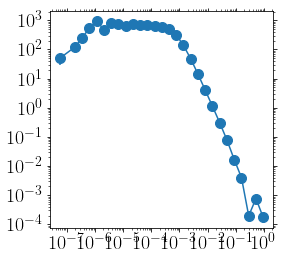

In [476]:
class MsDisp:
    
    def __init__(self, lmpDisp, #lmpVel, 
                 lmpCna, filtr):
        '''
        returns mean-squared displacements
        '''
        self.disp = lmpDisp.coord_atoms_broken
#        self.veloc = lmpVel.coord_atoms_broken
        self.cna = lmpCna.coord_atoms_broken
        
        self.times = list(lmpDisp.coord_atoms_broken.keys())
        self.times.sort()
#        print(self.times)
        self.filtr=filtr
        
    def Get(self,LOG=False):
        '''
        returns msd (no temporal window)
        '''
        if not LOG: #---  mean
            msd = list(map(lambda x:(self.disp[x]['DisplacementX']**2+\
                         self.disp[x]['DisplacementY']**2+\
                         self.disp[x]['DisplacementZ']**2).mean(),
                    self.times))
        else: #--- geometric mean
            msd = list(map(lambda x:10**((np.log10(self.disp[x]['DisplacementX']**2+\
                         self.disp[x]['DisplacementY']**2+\
                         self.disp[x]['DisplacementZ']**2)).mean()),
                    self.times))
        return np.array(msd)
        
    def GetPdfJumps(self):
        '''
        pdf's of jumps
        '''
        cols = ['DisplacementX','DisplacementY','DisplacementZ']
        for itime, itime0, count in zip(self.times[1:],self.times[:-1],range(len(self.times))):
            df=self.disp[itime]
            df0=self.disp[itime0]
            veloc = df[cols]-df0[cols]
            if count == 0:
                df_concat = np.c_[veloc]
            else:
                df_concat = np.concatenate([df_concat,veloc],axis=0) 
        df_abs = np.abs(df_concat.flatten())
        filtr = df_abs > 0.0
        
        hist, bin_edges, err = utl.GetPDF(df_abs[filtr],n_per_decade=4)
        utl.PltErr(bin_edges,hist, yerr=err,
                  yscale='log',
                   xscale='log',
        #           ylim=(1e-6,1e4)
                  )
        #
        with open('msd/event_jumps.txt','w') as fp:
            np.savetxt(fp,np.c_[bin_edges,hist,err],header='bin_edges hist err')

        
    def WindowAverage(self,ttime,bins_per_decade=4,LOG=False):
        '''
        returnd msd (include temporal windows)
        '''
        time_keys = np.arange(0,len(msd.times),2) #--- ignore half step
        assert len(ttime) == len(time_keys), 'must be of the same size!'

        for shift in range(1,len(time_keys)): #-1):
    #        shift = 1 #--- time index  shift
            dt = zip(time_keys,time_keys[shift:]) #--- time tuples
            dt_real = list(map(lambda x: x[1]-x[0], zip(ttime,ttime[shift:]))) #--- real time difference
            if not LOG: #---  mean
                disp = list(map(lambda x: ((self.disp[x[1]]['DisplacementX'][self.filtr]-self.disp[x[0]]['DisplacementX'][self.filtr])**2+\
                              (self.disp[x[1]]['DisplacementY'][self.filtr]-self.disp[x[0]]['DisplacementY'][self.filtr])**2+\
                              (self.disp[x[1]]['DisplacementZ'][self.filtr]-self.disp[x[0]]['DisplacementZ'][self.filtr])**2).mean(),
                    zip(time_keys,time_keys[shift:])))
            else:
                disp = list(map(lambda x: 10**((np.log10((self.disp[x[1]]['DisplacementX'][self.filtr]-self.disp[x[0]]['DisplacementX'][self.filtr])**2+\
                              (self.disp[x[1]]['DisplacementY'][self.filtr]-self.disp[x[0]]['DisplacementY'][self.filtr])**2+\
                              (self.disp[x[1]]['DisplacementZ'][self.filtr]-self.disp[x[0]]['DisplacementZ'][self.filtr])**2)).mean()),
                    zip(time_keys,time_keys[shift:])))
            
#            print(np.array(disp).shape)
            if shift == 1:
                tr_mat=np.c_[dt_real,disp]
            else:    
                tr_mat = np.concatenate([tr_mat,np.c_[dt_real,disp]],axis=0)
                
        #--- remove dt == 0
        filtr = tr_mat[:,0] > 0
        tr_mat = tr_mat[filtr]
#        print('dt_min=',tr_mat[:,0].min())
#        pdb.set_trace()

        return self.Binning(tr_mat,bins_per_decade)

#         #--- binning
#         xmin = 0.99*tr_mat[:,0].min()
#         xmax = 1.01*tr_mat[:,0].max()
#         n_decades = int(np.ceil(np.log10(xmax/xmin)))
#         bins = np.logspace(np.log10(xmin),np.log10(xmax),n_decades*bins_per_decade)
#         #
#         ysum, edges = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,1])
#         ysum_sq, edges = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,1]*tr_mat[:,1])
#         xsum, edges = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,0])
#         count, edges = np.histogram(tr_mat[:,0],bins=bins)
#         #
# #        filtr = count > 1
#         filtr = count > 0
#         ysum = ysum[filtr]
#         ysum_sq = ysum_sq[filtr]
#         xsum = xsum[filtr]
#         count = count[filtr]
#         assert not np.any(count == 0), 'incerease bin size!'
#         #
#         ysum_sq /= count
#         ysum /= count
#         xsum /= count
#         ysum_sq -= (ysum * ysum)
# #        assert not np.any(ysum_sq < 0.0), 'print %s'%ysum_sq
        
#         return np.c_[xsum,ysum,(ysum_sq/count)**0.5]
    
    def VacancyDynamics(self, title='void.xyz'):
        '''
        return xyz coordinates associated with vacancy 
        '''
        #--- unwrapped coordinates
        times = self.times[1:]
        times_ref = self.times[:-1]
        cols = ['DisplacementX','DisplacementY','DisplacementZ']
        xsum_concat=np.array([0,0,0])
        for itime, itime_ref in zip(times,times_ref):
            filtr = self.cna[itime_ref]['StructureType'] == 0.0 #--- neighboring atoms
            df=self.disp[itime]
            df0=self.disp[itime_ref]
            veloc = df[cols]-df0[cols]
            xsum = -np.array(veloc[filtr].sum()) #---disp
            xsum_concat = np.c_[xsum_concat,xsum]
        xsum_concat = xsum_concat.T
        xv = xsum_concat.cumsum(axis=0) #--- integrate
#        utl.PltErr(xv[:,0],xv[:,1])
        #--- add initial position
        itime=times_ref[0]
        filtr = self.cna[itime]['StructureType'] == 0.0
        rc = np.array(self.disp[itime][filtr]
                        [['x','y','z']].mean())
        #--- print
        try:
            os.system('rm msd/%s'%title)
        except:
            pass
        for itime in range(xv.shape[0]):
            sfile=open('msd/%s'%title,'a')
            utl.PrintOvito(pd.DataFrame(np.c_[xv[itime,:]+rc].reshape(1,3),columns=['x','y','z']), 
                       sfile, 'itime=%s'%itime, attr_list=['x', 'y', 'z'])
            
        self.xv = xv
        self.dxv = xsum_concat
        
    def msdVacancy(self,ttime,bins_per_decade=4,LOG=False):
        '''
        returnd msd(t) associated with motion of the vacancy
        '''
        time_keys = np.arange(0,len(msd.times),2) #--- ignore half step
        assert len(ttime) == len(time_keys), 'must be of the same size!'
        time_indices = np.arange(len(time_keys))
        for shift in range(1,len(time_keys)):
    #        shift = 1 #--- time index  shift
            dt = zip(time_keys,time_keys[shift:]) #--- time tuples
            dt_real = list(map(lambda x: x[1]-x[0], zip(ttime,ttime[shift:]))) #--- real time difference
            disp = list(map(lambda x: np.mean((self.xv[x[1]]-self.xv[x[0]])*(self.xv[x[1]]-self.xv[x[0]])),
                    zip(time_indices,time_indices[shift:])))
            
#            print(np.array(disp).shape)
            if shift == 1:
                tr_mat=np.c_[dt_real,disp]
            else:    
                tr_mat = np.concatenate([tr_mat,np.c_[dt_real,disp]],axis=0)
                
        #--- remove dt == 0
        filtr = tr_mat[:,0] > 0
        tr_mat = tr_mat[filtr]
        return self.Binning(tr_mat,bins_per_decade)
#        print('dt_min=',tr_mat[:,0].min())
#        pdb.set_trace()


    def Binning(self,tr_mat,bins_per_decade):
        #--- binning
        xmin = 0.99*tr_mat[:,0].min()
        xmax = 1.01*tr_mat[:,0].max()
        n_decades = int(np.ceil(np.log10(xmax/xmin)))
        bins = np.logspace(np.log10(xmin),np.log10(xmax),n_decades*bins_per_decade)
        #
        ysum, edges = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,1])
        ysum_sq, edges = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,1]*tr_mat[:,1])
        xsum, edges = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,0])
        count, edges = np.histogram(tr_mat[:,0],bins=bins)
        #
#        filtr = count > 1
        filtr = count > 0
        ysum = ysum[filtr]
        ysum_sq = ysum_sq[filtr]
        xsum = xsum[filtr]
        count = count[filtr]
        assert not np.any(count == 0), 'incerease bin size!'
        #
        ysum_sq /= count
        ysum /= count
        xsum /= count
        ysum_sq -= (ysum * ysum)
#        assert not np.any(ysum_sq < 0.0), 'print %s'%ysum_sq
        
        return np.c_[xsum,ysum,(ysum_sq/count)**0.5]
    

!mkdir msd
msd = MsDisp( lmpDisp, #lmpVel, 
             lmpCna,
              np.ones(lmpDisp.coord_atoms_broken[0].shape[0],dtype=bool) #--- filter 
            )
#
msd.GetPdfJumps() #--- jump distributions

#---  vacancy
msd.VacancyDynamics(title='void2.xyz')
vac_data = msd.msdVacancy(lmpData.headers['Time'][::2],bins_per_decade=4,LOG=False)

#--- correlated noise
xvv = np.c_[list(map(lambda x:msd.dxv[x]+msd.dxv[x+1],range(1,msd.dxv.shape[0],2)))] #--- include half steps
with open('msd/noise.txt','w') as fp:
    np.savetxt(fp,np.c_[lmpData.headers['Time'][1:-1:2],xvv],header='time dx dy dz')

# #
ans = msd.WindowAverage(lmpData.headers['Time'][::2],bins_per_decade=4,LOG=False) #---msd
# ans_logAveraged = msd.WindowAverage(lmpData.headers['Time'][::2],bins_per_decade=4,LOG=True)
# #
# #
with open('msd/msd.txt','w') as fp:
    np.savetxt(fp,ans,header='t\tmsd\terr')
#
#with open('msd/msd_logAveraged.txt','w') as fp:
#    np.savetxt(fp,ans_logAveraged,header='t\tmsd\terr')
#
with open('msd/event_times.txt','w') as fp:
    np.savetxt(fp,lmpData.times,header='t')
#
with open('msd/timeseries.txt','w') as fp:
    np.savetxt(fp,np.c_[lmpData.headers],header='Barrier Energy Step Time')
#
with open('msd/msd_vac.txt','w') as fp:
    np.savetxt(fp,vac_data,header='t\tmsd\terr')

#--- correlated noise
xvv = np.c_[list(map(lambda x:msd.dxv[x]+msd.dxv[x+1],range(1,msd.dxv.shape[0],2)))] #--- include half steps
with open('msd/noise.txt','w') as fp:
    np.savetxt(fp,np.c_[lmpData.headers['Time'][1:-1:2],xvv],header='time dx dy dz')

#--- filter based on atom types
# types = list(set(lmpDisp.coord_atoms_broken[0]['type']))
# for itype in types:
#     filtr = lmpDisp.coord_atoms_broken[0]['type'] == itype
#     msd = MsDisp( lmpDisp, lmpVel,
#               filtr #--- filter 
#             )
#     ans = msd.WindowAverage(lmpData.times,bins_per_decade=4)
#     #--- print
#     with open('msd/msd_type%s.txt'%itype,'w') as fp:
#         np.savetxt(fp,ans,header='t\tmsd\terr')
#     with open('msd/event_times_type%s.txt'%itype,'w') as fp:
#         np.savetxt(fp,lmpData.times,header='t')



## Energy barriers

In [ ]:
class EnergyBarrier:
    '''
    return energy barriers corresponding to diffusional hopping
    '''
    def __init__(self,events_directory,evlist_directory,lmpData):
        self.events_dir = events_directory
        self.evlist_dir = evlist_directory
        self.lmpData = lmpData.coord_atoms_broken[0]
        
    def Parse(self):
        '''
        parse event files
        '''
        self.events_id_energy = self.ParseEvents_dir()
        self.catalog = self.ParseEvList_dir()
        
        
    def ParseEvents_dir(self):
        files = os.listdir(self.events_dir)
        d=[]
        for sfile in files:
            if not '.xyz' in sfile: #--- skip .xyz files 
                try:
                    filee=open('%s/%s'%(self.events_dir,sfile)) #--- open file
                    xstrs = filee.readlines()
                    event_id = int(xstrs[0].split()[-1]) #--- event id
                    barrier = float(xstrs[2].split()[-1]) #--- energy
                    ncluster =  int(xstrs[15].split()[-1])                 
                    shape_cluster_atoms =  int(xstrs[16].split()[-1])
                    atom_id = int(xstrs[17+ncluster].split()[0])
                    #print(atom_id)
                    d = np.c_[event_id,atom_id,barrier] if len(d) == 0 else\
                    np.concatenate([d,np.c_[event_id,atom_id,barrier]])
#                    d.setdefault(event_id,[]).append(barrier) #--- store
                except:
        #            traceback.print_exc()
                    continue
            
        #--- extract types
        df=self.lmpData
        atom_ids = d[:,1]
        types = utl.FilterDataFrame(df, 
                    key='id', 
                    val=atom_ids
                   )['type']

        return pd.DataFrame(np.c_[types,d],columns=['atom_type','event_id','atom_id','barrier'])

    def ParseEvList_dir(self):
        files = os.listdir(self.evlist_dir)
        events={}
        for sfile in files:
            try:
                kmc_step = int(sfile.split('_')[-1])
        #        print(kmc_step)
                filee=open('%s/%s'%(self.evlist_dir,sfile)) #--- open file
                events[kmc_step] = pd.read_csv(filee,delim_whitespace=True).iloc[1:]#delimiter='')
            except:
                continue
        return events
        
    def SplitByType(self):
        '''
        return energies (parsed from catalogs) slipt by atom types
        '''
        kmc_steps = list(self.catalog.keys())
        kmc_steps.sort()


        #--- dict based on types
        df_concat = {}
        types = list(set(self.lmpData.type))
        for itype in types:
            df_concat[str(itype)] = {}

        for kmc_step in kmc_steps: #--- kmc loop
            df = self.catalog[kmc_step]
            sdict=df.groupby(by='#TypeId').groups #--- group by type
            for itype in sdict:
                indices = sdict[itype] #--- row index: atoms with  '#TypeId' == itype
                cond = len(df_concat[itype]) == 0 #--- empty key?
                df_concat[itype] = np.c_[df.loc[indices]] if cond else\
                np.concatenate([df_concat[itype],np.c_[df.loc[indices]]],axis=0)

        self.energyByType = {}
        for itype in df_concat:
             self.energyByType[ itype ] = pd.DataFrame(df_concat[itype],columns=list(df.keys()))        

eb = EnergyBarrier('%s/EVENTS_DIR'%confParser['input files']['input_path'],
                   '%s/EVLIST_DIR'%confParser['input files']['input_path'],
                   lmpData
                  
                  )
eb.Parse()
eb.SplitByType()

#eb.events_id_energy extract from Events_dir
#self.energyByType extract from catalogs

#--- write to file
with open('msd/eventID_barrier.txt','w') as fp:
    np.savetxt(fp,
               np.c_[eb.events_id_energy],
               header='atom_type event_id atom_id barrier')

#--- write to file: energy from catalogs
for itype in eb.energyByType.keys():
    with open('msd/eventID_barrier_catalog_type%s.txt'%itype,'w') as fp:
    #--- concat different types
        sarr = np.c_[eb.energyByType[itype][['AtomId','eventId','barrier']]].astype(float)
        np.savetxt(fp,
                   sarr,
                   header='AtomId eventId barrier'
                  )


In [ ]:
# sarr = np.concatenate(list(d.values()))
# hist,edges,err=utl.GetPDF(sarr,n_per_decade=8)
# utl.PltErr(edges,hist,yerr=err,xscale='log',yscale='log')

In [ ]:
#--- assert events in catalogs are included in event dir


    #    Energy_type[int(keys)] = np.c_[df.loc[indices]]
    #    Energy_type[int(keys)].setdefault()
    # for kmc_step in kmc_steps:
    #     print(kmc_step)
    #     trueFalse = list(map(lambda x: int(x) in eb.events_id_energy.keys() ,eb.catalog[kmc_step]['eventId']))
    #     assert np.all(trueFalse),'modes %s are missing!'%(list(eb.catalog[kmc_step]['eventId'][~np.array(trueFalse)]))


In [ ]:
#--- plot energy per atom
# d={}
# for kmc_step in kmc_steps:
#     for items in np.c_[eb.catalog[kmc_step][['AtomId','barrier']]]:
#         d.setdefault(int(items[0]),[]).append(float(items[1]))

In [ ]:
# itime=90
# #filtr = msd.cna[itime].StructureType==0.0
# filtr=msd.veloc[itime].DisplacementX.abs() > 0.1
# assert np.any(filtr)
# idd = msd.veloc[itime][filtr].id.iloc[0]
# #msd.veloc[itime][filtr]

# times=list(msd.disp.keys())
# times.sort()
# #idd=10
# dispx={}
# itimec=itime
# for itime in times:
#     filtr= msd.disp[itime].id==idd
#     dispx[itime]=msd.disp[itime].DisplacementX[filtr]
# tt=lmpData.headers.Time.iloc[0::2]
# utl.PltErr(tt,
#            list(map(lambda x:dispx[x],times[0::2])),
# #           attrs={'fmt':'.'},
#            xlim=(tt[itimec-2],tt[itimec+2]),
#            attrs={'marker':'o',
#                   'markersize':6,
#                   'drawstyle':'steps-post'}
           
#           )

In [ ]:
# tt=lmpData.headers.Time.iloc[0::2]
# utl.PltErr(tt,msd.xv[:,0][0::2],
#             xlim=(tt[100],tt[130]),
#             ylim=(5,22),
#            attrs={'marker':'o',
#                   'markersize':8,
#                   'drawstyle':'steps-post'}
#           )

# # utl.PltErr(tt,msd.xv[:,1][0::2],
# # #            xlim=(tt[100],tt[130]),
# # #            ylim=(5,25),
# #            attrs={'marker':'o',
# #                   'markersize':8,
# #                   'drawstyle':'steps-post'}
# #           )

# # utl.PltErr(tt,msd.xv[:,2][0::2],
# # #            xlim=(tt[100],tt[130]),
# # #            ylim=(5,25),
# #            attrs={'marker':'o',
# #                   'markersize':8,
# #                   'drawstyle':'steps-post'}
# #           )

In [ ]:
# tt=lmpData.headers.Time.iloc[0::2]
# utl.PltErr(tt,msd.xv[:,0][0::2],
#             xlim=(tt[0],tt[50]),
#             ylim=(0,10),
#            attrs={'marker':'s',
#                   'markersize':8,
#                   'drawstyle':'steps-post'}
#           )

In [ ]:
# data = np.loadtxt('xxbarriers.txt')[:,1]

# hist, bin_edges, err = utl.GetPDF(data,n_per_decade=16)
# symbols=utl.Symbols()
# #--- plot
# utl.PltErr(bin_edges,hist,
#               yerr=err,
#        attrs=symbols.GetAttrs(),
#            xscale='log',
#            yscale='log'
#               )
            
            

In [ ]:
# lmpData.headers #.Time.iloc[0::2]

In [ ]:
# lmpData.coord_atoms_broken.keys()

In [ ]:
# !mkdir png
# symbols=utl.Symbols()

# # ans=ans_tot
# ax=utl.PltErr(ans_logAveraged[:,0],ans_logAveraged[:,1],
#            yerr=ans_logAveraged[:,2],
#            attrs=symbols.GetAttrs(count=0),
#            Plot=False,
#           )

# ax=utl.PltErr(ans[:,0],ans[:,1],
#            yerr=ans[:,2],
#            ax = ax,
#            attrs=symbols.GetAttrs(count=1),
#            Plot=False,
#           )
# utl.PltErr(None,#lmpData.times[1:],
#            None, #msd.Get()[1:],
#           xscale='log',
#           yscale='log',
#            attrs={'fmt':'-'},
#            ax=ax,
# #           ylim=(1e-4,1e-1),
#            xstr=r'$t\mathrm{(s)}$',
#            ystr=r'msd(A$^2$)',
#            title='png/msd.png'
#           )

## arrhenius law

mkdir: png: File exists
ensemble average


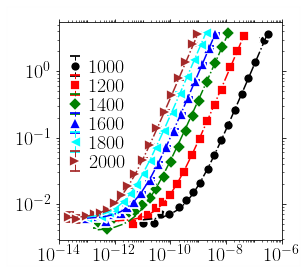

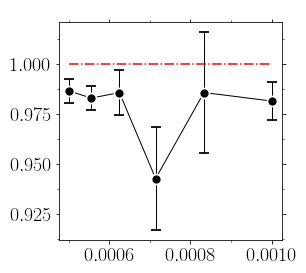

In [26]:
class Temperature:
    
    def __init__(self,temp_range,nrun,verbose=False):
        self.temps =  temp_range
        self.nrun = nrun
        t,r=np.meshgrid(self.temps,np.arange(nrun),indexing='ij')
        self.temps_runs = np.array(list(zip(t.flatten(),r.flatten())))
        self.verbose = verbose
        
    def Parse(self,dirs):
#         print('dirs:',dirs)
        self.data=list(map(lambda x:np.loadtxt(x,ndmin=2),dirs))
        if self.verbose:
            list(map(lambda x:print('Parsing: data.shape is',x.shape),self.data))
#        print('np.array(self.data):',np.array(self.data))

        
    def Plot(self,**kwargs):
#        print(list(self.temps_runs))
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)

        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5)
                   )
        for data, temp_run, count in zip(self.data,self.temps_runs,range(len(self.data))): 
            temp = temp_run[0]
            try:
                utl.PltErr(data[:,0],data[:,1],
                       yerr=data[:,2],
                       ax = self.ax,
                       attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp),
                       Plot=False,
                      )
            except:
                continue
        #
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
                   DrawFrame=DRAW_FRAME,
#                 legend=legends.Get(),
                   **kwargs
                  )
        
    def EnsAverage(self,log_scale=False,n_bins_per_decade=6):
        kount = 0
        self.data_averaged = {} #np.zeros(len(self.temps))
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            data = self.data[kount:kount+self.nrun]
            if self.verbose:
                print('data.shape:',np.array(data).shape)
#             print('np.array(data):',np.array(data))
#             pdb.set_trace()
    
            filtr = list(map(lambda x:x.shape[0] > 0,data)) #--- filter empty arrays
    
            data = np.concatenate(np.array(data)[filtr]) #,axis=0)
            self.data_averaged[ temp ] = self.hist(data,log_scale,n_bins_per_decade=n_bins_per_decade)
            kount += self.nrun

    def hist(self,data,log_scale,n_bins_per_decade=6):
        n_thresh = 2
            #--- average
        xdata = data[:,0]
        ydata = data[:,1]
        xmin = np.floor(np.log10(xdata).min())
        xmax = np.ceil(np.log10(xdata).max())
        n_decades = int((xmax - xmin))
        bins = np.logspace(xmin,xmax,n_decades*n_bins_per_decade)
        #
        count, _ = np.histogram(xdata,bins=bins)
        xsum, _  = np.histogram(xdata,bins=bins,weights=xdata)
        weights = ydata if not log_scale else np.log10(ydata)
        ysum, _  = np.histogram(xdata,bins=bins,weights=weights)
        ysum_sq, _  = np.histogram(xdata,bins=bins,weights=weights*weights)
        #
        xsum = xsum[count>n_thresh]
        ysum = ysum[count>n_thresh]
        ysum_sq = ysum_sq[count>n_thresh]
        count = count[count>n_thresh]
        #
        xsum /= count
        ysum /= count
        ysum_sq /= count
        std = np.sqrt((ysum_sq - ysum * ysum)/count)
        if log_scale:
            ysum = 10 ** ysum
            std = 0.5 * ysum * (1+2*std*np.log(10))
        return np.c_[xsum,ysum,std]
        
        
#            utl.PltErr(xsum,ysum,ax=self.ax)
            

    def PlotAverage(self,rescale=False,**kwargs):
#        print(list(self.temps_runs))
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)

        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5))
        for temp, count in zip(self.temps,range(len(self.temps))): 
            data = self.data_averaged[ temp ]
            xdata = data[:,0]
            ydata = data[:,1]
            yerr = data[:,2]
            if rescale:
                ydata /= xdata
                yerr /= xdata
            utl.PltErr(xdata,ydata,
                   yerr=yerr,
                   ax = self.ax,
                   attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp,nevery=1),
                   Plot=False,
                  )

        utl.PltErr(None,
                   None, 
                   ax=self.ax,
                   Plot=False,
#                    legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
        
        
    def func2nd(self,x,y0,c0,alpha):
#        return y0+c0*(x/x0)**alpha
        return y0+c0*x**alpha
#     def func2nd(self,x,y0,m0):
#         return y0+m0*x

    def Fit(self,Plot=None,
            shift = False,
#             SIGMA=False,
            plotAttrs=None,
            bounds=(-np.inf, np.inf),
            xlo=float('-inf'),xhi=float('inf'),
            **kwargs):
        self.Diffusion = {}
        self.exponent = {}
        pref=1e-10*1e-10 #--- ang^2 to m^2
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=plotAttrs['bbox_to_anchor'] if 'bbox_to_anchor' in plotAttrs
                    else (1.0,0.5,0.5,0.5))

        if Plot:
            ax = utl.PltErr(None,None,
                            Plot=False)
        #
        for temp, count in zip(self.temps,range(len(self.temps))): 
            self.smat = smat = self.data_averaged[ temp ] if self.nrun > 1 else self.data[count]

            xdata=smat[:,0]
            ydata=smat[:,1]
            yerr = smat[:,2]
#             print(smat)

        
            #--- set limits:
            if self.verbose:
                print('limits:',xlo,xhi)

            filtr = np.ones(xdata.shape[0],dtype=bool)
            filtr = np.all([filtr,xdata > xlo],axis=0)
            filtr = np.all([filtr,xdata <= xhi],axis=0)
            assert np.any(filtr), 'empty arrays!'
            if self.verbose:
                print('filtr=',filtr)
            
            #--- error in y
            if 'sigma' in kwargs:
                kwargs['sigma'] = 2*yerr[filtr]

            #--- fit
#             print(kwargs)
            popt, pcov = curve_fit(self.func2nd, xdata[filtr], ydata[filtr],
                                   bounds=bounds, #([1e-1, 1e5,0.5], [1e0, 1e7,2.0]), #[(4e-3, 1e5,0.5), (1e-2, 1e7,2.0)],#bounds,
                                    **kwargs
                                    )
            self.popt = popt
            self.filtr = filtr
            #--- uncertainties
            if self.verbose:
                print('Temp=%s,y0,c0,alpha'%temp,list(popt),pcov)
            y0=popt[0]
            alpha=popt[2]
            err_alpha = pcov[2,2]**0.5
            c0=popt[1]
            dc = pcov[1,1]**0.5
            tau=1#popt[0]
            dtau=0#pcov[0,0]**0.5
            self.time_scale = tau * (y0/c0)**(1/alpha)
#             self.Diffusion[temp] = [pref*c0/tau,pref*c0/tau,pref*c0/tau]
            self.Diffusion[temp] = [pref*c0/(tau)**alpha, pref*(c0+dc)/(tau-dtau)**alpha, 
                                    pref*(c0-dc)/(tau+dtau)**alpha]
            self.exponent[temp] = [alpha,alpha+err_alpha,alpha-err_alpha]
            if Plot:
                #---fit
                y0=0 #kam
                xdata_shift = xdata*20**count if shift else xdata
                utl.PltErr(xdata_shift,
                                (self.func2nd(xdata,*popt)-y0),#-y0)/xdata_shift,
                                attrs={'fmt':'-.','color':symbols.colors[count%7]},
                           Plot=False,ax=ax)
                #--- points
#                temp= [1000,1200,1400,1600,1800,2000][count]
                utl.PltErr(xdata_shift,
                           (ydata-y0),#-y0)/xdata_shift,
                           yerr=(yerr),#-y0),#/xdata_shift,
                           attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp,fmt='.'),
                           ax=ax,
                           Plot=False,
                          )
        if Plot:
            utl.PltErr(None,
                       None, 
                       ax=ax,
                       Plot=False,
                       legend=legends.Get(),
                       DrawFrame=DRAW_FRAME,
                       **plotAttrs
                      )

    def PlotDiff(self,**kwargs):
        symbols=utl.Symbols()
        utl.PltErr(1.0/np.array(self.temps),
                   list(map(lambda x:self.Diffusion[x][0],self.temps)),
                   yerr=list(map(lambda x:(self.Diffusion[x][1]-self.Diffusion[x][2])/2,self.temps)),
                   attrs=symbols.GetAttrs(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )

    def PlotExponent(self,**kwargs):
        symbols=utl.Symbols()
        ax=utl.PltErr([0.5e-3,1e-3],[1,1],attrs={'fmt':'-.r'},Plot=False)
        utl.PltErr(1.0/np.array(self.temps),
                   list(map(lambda x:self.exponent[x][0],self.temps)),
                   yerr=list(map(lambda x:1.0*(self.exponent[x][1]-self.exponent[x][2]),self.temps)),
                   attrs=symbols.GetAttrs(),
                   DrawFrame=DRAW_FRAME,
                   ax=ax,
                   **kwargs
                  )

if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    #--- temp object
    temp = Temperature(
#        [1000,1200,1400,1600,1800,2000],8,
#        [1000,1200,1400,1600,1800,2000],8,
#       [1000,1200,1400,1600,1800,2000],1,
       [1000,1200,1400,1600,1800,2000],8,
#         verbose = True,
                     )
    #
    #--- parse data
#    temp.Parse(['./msd/msd.txt'])
#    temp.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/msd.txt'%(x[0],x[1]),
#    temp.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/msd.txt'%(x[0],x[1]),
#    temp.Parse( list(map(lambda x:'NiNatom16KTemp%sK/Run%s/msd/msd.txt'%(x[0],x[1]),
    temp.Parse( list(map(lambda x:'NiNatom1KTemp%sK/Run%s/msd/msd.txt'%(x[0],x[1]),
                        temp.temps_runs ))
             )
    #
    #--- plot
#     print('single realizations')
#     temp.Plot(**{
#                   'xscale':'log',
#                   'yscale':'log',
#                    'attrs':{'fmt':'-'},
# #                   'xlim':(1e-10,1e-3),
# #                    'ylim':(1e-5,1e-1),
# #                   'xstr':r'$t\mathrm{(s)}$',
# #                   'ystr':r'msd(A$^2$)',
# #                   'title':'png/msd_temp_ni.png',
#         'bbox_to_anchor':(0.01,0.3,0.5,0.5)
#     })
    #
    #--- plot average
    #
    if temp.nrun > 1:
        print('ensemble average')
        temp.EnsAverage(log_scale=False,n_bins_per_decade=4)
#         temp.PlotAverage(**{
#                   'yscale':'log',
#                   'xscale':'log',
# #                   'xlim':(1e-10,1e-3),
# #                    'ylim':(1e-4,1e-1),
# #                     'xstr':r'$t\mathrm{(s)}$',
# #                   'ystr':r'msd(A$^2$)',
#                    'title':'png/msd_temp_cantor.png',
#         })

    #
    #--- fit
    #
    temp.Fit(Plot=True,
#             shift=True,
#             bounds=([4e-3, 1e5,0.5], [1e-2, 1e7,2.0]),
            p0=[[1e-4, 1e6, 1.0]],
#            p0=[[1e-2, 1e6, 1.0]],
             sigma=True, #--- comment for ni
#             xlo=1e-12,
             plotAttrs={'yscale':'log',
                  'xscale':'log',
#                   'xlim':(4e-13,8e-4),
#                   'ylim':(1e-4,1e-1),
#                     'xstr':r'$t\mathrm{(s)}$',
#                   'ystr':r'msd(A$^2$)',
                        'ndecade_x':2,
                    'bbox_to_anchor':(-0.05,0.23,0.5,0.5),
                   'title':'png/msd_temp_niChoi_fit.png'},
            )
    
#     temp.PlotDiff(**{
#                   'yscale':'log',
# #                   'xlim':(1e-12,1e-3),
# #                   'ylim':(1e-4,1e-1),
# #                   xstr=r'$1/T(K^{-1})$',
# #                   ystr=r'$D(m^2/s)$',
#                     'title':'png/D_temp_cantor.png',
#                     }
#                 )

    temp.PlotExponent(**{
#                  'yscale':'log',
#                   'xlim':(1e-10,1e-3),
#                   'ylim':(.5,1.1),
#                   xstr=r'$1/T(K^{-1})$',
#                   ystr=r'$D(m^2/s)$',
#                    'title':'png/alpha_temp_ni.png',
                    }
                )
    


### vacancy dynamics

mkdir: png: File exists
ensemble average


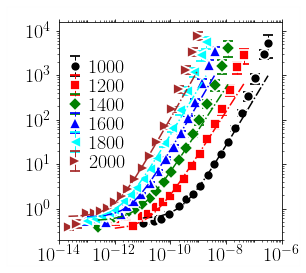

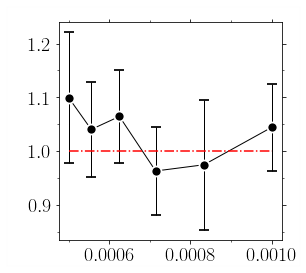

In [27]:
if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    #--- temp object
    temp_vac = Temperature(
        [1000,1200,1400,1600,1800,2000],8,
#        [2000],8,
#        [1000,1200,1400,1600,1800,2000],1,
#       [1000,1200,1400,1600,1800,2000],1,
#        np.arange(1000,1440,80),1,
#         verbose = True,
                     )
    #
    #--- parse data
#    temp_vac.Parse(['./msd/msd.txt'])
#    temp_vac.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/msd_vac.txt'%(x[0],x[1]),
#    temp_vac.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/msd_vac.txt'%(x[0],x[1]),
#    temp_vac.Parse( list(map(lambda x:'NiNatom16KTemp%sK/Run%s/msd/msd_vac.txt'%(x[0],x[1]),
    temp_vac.Parse( list(map(lambda x:'NiNatom1KTemp%sK/Run%s/msd/msd_vac.txt'%(x[0],x[1]),
                        temp_vac.temps_runs ))
             )
    #
    #--- plot
#     print('single realizations')
#     temp_vac.Plot(**{
#                   'xscale':'log',
#                   'yscale':'log',
#                    'attrs':{'fmt':'-'},
# #                   'xlim':(1e-10,1e-3),
# #                    'ylim':(1e-5,1e-1),
# #                   'xstr':r'$t\mathrm{(s)}$',
# #                   'ystr':r'msd(A$^2$)',
# #                   'title':'png/msd_temp_ni.png',
#         'bbox_to_anchor':(0.01,0.3,0.5,0.5)
#     })
    #
    #--- plot average
    #
    if temp_vac.nrun > 1:
        print('ensemble average')
        temp_vac.EnsAverage(log_scale=False,n_bins_per_decade=4)
#         temp_vac.PlotAverage(**{
#                   'yscale':'log',
#                   'xscale':'log',
# #                   'xlim':(1e-10,1e-3),
# #                    'ylim':(1e-4,1e-1),
# #                     'xstr':r'$t\mathrm{(s)}$',
# #                   'ystr':r'msd(A$^2$)',
#                    'title':'png/msd_temp_cantor.png',
#         })

    #
    #--- fit
    #
    temp_vac.Fit(Plot=True,
#             shift=True,
#             bounds=(np.array([1e-1, 1e5,0.8]), np.array([4e-1, 1e7,2.0])),
            p0=[[1e0, 1e6, 1.0]],
#             p0=[[-1, 1e6, 1.0]],
             sigma=True, #--- comment for ni
#              xlo=2e-9,
             plotAttrs={'yscale':'log',
                  'xscale':'log',
#                   'xlim':(4e-13,8e-4),
#                   'ylim':(1e-4,1e-1),
#                     'xstr':r'$t\mathrm{(s)}$',
#                   'ystr':r'msd(A$^2$)',
                        'ndecade_x':2,
                    'bbox_to_anchor':(-0.05,0.23,0.5,0.5),
                   'title':'png/msd_temp_niChoi_fit_vac.png'},
            )
    
#     temp.PlotDiff(**{
#                   'yscale':'log',
# #                   'xlim':(1e-12,1e-3),
# #                   'ylim':(1e-4,1e-1),
# #                   xstr=r'$1/T(K^{-1})$',
# #                   ystr=r'$D(m^2/s)$',
#                     'title':'png/D_temp_cantor.png',
#                     }
#                 )

    temp_vac.PlotExponent(**{
#                  'yscale':'log',
#                   'xlim':(1e-10,1e-3),
#                   'ylim':(.5,1.1),
#                   xstr=r'$1/T(K^{-1})$',
#                   ystr=r'$D(m^2/s)$',
#                    'title':'png/alpha_temp_nicocr_vac.png',
                    }
                )
    


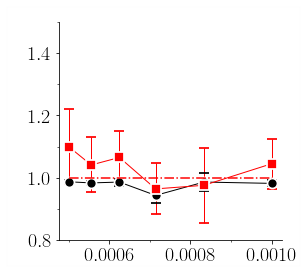

In [29]:
if not eval(confParser['flags']['RemoteMachine']):
    symbols=utl.Symbols()
    legends = Legends()
    legends.Set(bbox_to_anchor=(0.05,-0.15,0.5,0.5))
    #
    ax=utl.PltErr([0.5e-3,1e-3],[1,1],attrs={'fmt':'-.r'},Plot=False)
    utl.PltErr(1.0/np.array(temp.temps),
               list(map(lambda x:temp.exponent[x][0],temp.temps)),
               yerr=list(map(lambda x:1.0*(temp.exponent[x][1]-temp.exponent[x][2]),temp.temps)),
               attrs=symbols.GetAttrs(count=0,label=r'$\mathrm{Total}$'),
               ax=ax,
               Plot=False,
    #           **kwargs
              )

    utl.PltErr(1.0/np.array(temp_vac.temps),
               list(map(lambda x:temp_vac.exponent[x][0],temp_vac.temps)),
               yerr=list(map(lambda x:1.0*(temp_vac.exponent[x][1]-temp_vac.exponent[x][2]),temp_vac.temps)),
               attrs=symbols.GetAttrs(count=1,label=r'$\mathrm{Vacancy}$'),
               DrawFrame=DRAW_FRAME,
               ax=ax,
                       ylim=(.8,1.5),
               halfopen=True,
    #           legend=legends.Get(),
                        title='png/alpha_temp_ni.png',
              )


### robustness

In [ ]:
class Robustness(Temperature):
    
    def __init__(self,temp_range,nrun,verbose=False):
        Temperature.__init__(self,temp_range,nrun,verbose=verbose)

    def FitRange(self,decades=9):
        self.Fit(Plot=False,shift=False,
                    p0=[[1e-2, 1e6, 1.0]],
                 sigma=True, #--- comment for ni
                     plotAttrs={'bbox_to_anchor':(-0.05,0.23,0.5,0.5)}
                )

        self.xlo = np.floor(np.log2(self.smat[:,0].min()))
        xhii = np.ceil(np.log2(self.smat[:,0].max()))
        self.xrange = 2**np.arange(xhii+1,xhii-decades,-1)
        
    def Fitting(self):
        #--- bounds
        self.exponents = np.zeros(len(self.xrange))
        self.error = np.zeros(len(self.xrange))
        self.npoin = np.zeros(len(self.xrange))
        
        npoint_filtrd0 = self.smat.shape[0]
        for xhi, indx in zip(self.xrange,range(len(self.xrange))):
            self.Fit(Plot=True,
                     shift=False,
        #             bounds=([0, 0, 0,0.999], [1e-2, 1e-3, 1,1.001]),
                        p0=[[1e-2, 1e6, 1.0]],
                     sigma=True, #--- comment for ni
                     xlo=2**self.xlo,xhi=xhi,
                     plotAttrs={'yscale':'log',
                          'xscale':'log',
        #                   'xlim':(4e-13,8e-4),
        #                   'ylim':(1e-4,1e-1),
        #                     'xstr':r'$t\mathrm{(s)}$',
        #                   'ystr':r'msd(A$^2$)',
                                'ndecade_x':2,
                            'bbox_to_anchor':(-0.05,0.23,0.5,0.5),
    #                       'title':'png/msd_temp_nicocr_fit.png'
                               },
                    )
            
            #--- check if decrease in tc leads to fewere points
#             npoint_filtrd = np.sum(self.filtr)
#             if self.verbose:
#                 print('npoint_filtrd=',npoint_filtrd)
#             #if indx > 0:
#             if npoint_filtrd == npoint_filtrd0 and indx > 0:
#                 continue
# #                    , '%s >= %sdecrease ndecades!'%(npoint_filtrd,npoint_filtrd0)
#             npoint_filtrd0 = npoint_filtrd
            
            #--- assign
            self.npoin[indx] = np.sum(self.filtr)
            if self.npoin[indx] == self.npoin[indx-1] and indx > 0:
                continue
            self.exponents[indx] = self.popt[-1]
            x = self.temps[ 0 ]
            self.error[indx] = 0.5*(self.exponent[x][1]-self.exponent[x][2])
        
if not eval(confParser['flags']['RemoteMachine']):

    symbols = utl.Symbols()
    ax = utl.PltErr(None,None,Plot=False)

    temps = [1200] #[1000,1200,1400,1600,1800,2000]
    indices = [1] #range(10)
    for temperature, indx in zip(temps,indices):
        try:
            rb = Robustness([temperature],8,
#                            verbose = True

                            )

            #--- parse data
#            rb.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/msd.txt'%(x[0],x[1]),
            rb.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/msd.txt'%(x[0],x[1]),
#            rb.Parse( list(map(lambda x:'NiNatom16KTemp%sK/Run%s/msd/msd.txt'%(x[0],x[1]),
                                rb.temps_runs ))
                     )

            #--- plot average
            if rb.nrun > 1:
                print('ensemble average')
                rb.EnsAverage(log_scale=False,n_bins_per_decade=4)
#                 rb.PlotAverage(**{
#                           'yscale':'log',
#                           'xscale':'log',
#         #                   'xlim':(1e-10,1e-3),
#         #                   'ylim':(1e-4,1e-1),
#         #                     'xstr':r'$t\mathrm{(s)}$',
#         #                   'ystr':r'msd(A$^2$)',
# #                            'title':'png/msd_temp_cantor.png',
#                 })
            #
            #--- fit
            #
            rb.FitRange(decades=10)
            rb.Fitting()


            #--- get data
            filtr = np.all([rb.exponents>0,rb.exponents<2],axis=0)
            utl.PltErr(rb.xrange[filtr],rb.exponents[filtr],yerr=rb.error[filtr],
                       attrs=symbols.GetAttrs(count=indx%7),
                       ax=ax,
                        Plot=False,
                      )
        except:
            print('increase fit range!')
            traceback.print_exc()
            continue

    utl.PltErr(ax.axis()[:2],[1,1],Plot=False,ax=ax,
                attrs={'fmt':'-.','color':'red'},
                       ylim=(0,2),
                      xscale='log',
                       DrawFrame=DRAW_FRAME,
                       title='png/exponentH_ni_T%sK.png'%temperature,
              )

### per type

In [ ]:
if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    ax = utl.PltErr(None,None,Plot=False)
    symbols=utl.Symbols()
    legends = Legends()
    legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))
 
                       
    ntype = 5
    for itype in range(1,ntype+1):
        temp = Temperature(#[1000],3
                           list(map(int,np.linspace(1000,1400,11))),3
                          )
        temp.Parse( list(map(lambda x:'CantorNatom16KTemp%sK_ensemble/Run%s/msd/msd_type%s.txt'%(x[0],x[1],itype),
                            temp.temps_runs ))
                  )
        #
  #      print('single realizations')
  #      temp.Plot()
        #
        print('ensemble average: type %s'%itype)
        temp.EnsAverage()
#         temp.PlotAverage()
#         #
        temp.Fit(#Plot=True,
        #         verbose=True
        )
#         temp.PlotDiff()
        
        #--- plot
        utl.PltErr(1/np.array(list(temp.Diffusion.keys())),
                   list(map(lambda x:temp.Diffusion[x],list(temp.Diffusion.keys()))),
                       Plot=False,
                   ax=ax,
                   attrs=symbols.GetAttrs(count=(itype-1)%7,label=r'$%s$'%temp),
                 )
    utl.PltErr(None,None,
               ax=ax,
               yscale='log',
               ylim=(1e-15,1e-11),
              xstr=r'$1/T(K^{-1})$',
              ystr=r'$D(m^2/s)$',
              )

In [ ]:
tauu = temp.time_scale

## correlated noise

mkdir: png: File exists


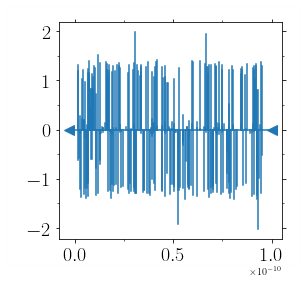

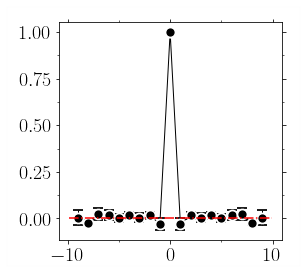

In [626]:
class Noise(Temperature):
    def __init__(self,temp_range,nrun,verbose=False):
        Temperature.__init__(self,temp_range,nrun)
        self.verbose = verbose
    #
    def PlotNoise(self, col_a = 1, col_b=1,
                  **kwargs):
        #
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))
        #
        self.crltns_mean_ab = {}
        self.crltns_mean_ba = {}
        self.crltns_err_ab = {}
        self.crltns_err_ba = {}
        kount = 0
        #
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            data = self.data[kount:kount+self.nrun]
            if self.verbose:
                print('data.shape (per temperature):',np.array(data).shape)
                
            #--- correlations
            crltns_ab = np.c_[list(map(lambda x: Noise.Crltns(x[:,col_a],x[:,col_b]),data))]
            crltns_ba = np.c_[list(map(lambda x: Noise.Crltns(x[:,col_b],x[:,col_a]),data))]
            self.crltns_mean_ab[temp] = np.mean(crltns_ab,axis=0)
            self.crltns_mean_ba[temp] = np.mean(crltns_ba,axis=0)
            self.crltns_err_ab[temp] = np.std(crltns_ab,axis=0)/self.nrun**0.5
            self.crltns_err_ba[temp] = np.std(crltns_ba,axis=0)/self.nrun**0.5
            kount += self.nrun
        #--- plot
        irun = 0
        smat=data[irun]
        for i,j in zip(smat[:,0],smat[:,col_a]):
            utl.PltErr([i,i],[0,j],
                       attrs={'fmt':'-','color':'C0'},
                       ax=self.ax,
                       Plot=False,
#                       **kwargs
                      )
        utl.PltErr(self.ax.axis()[:2],[0,0],
                        ax=self.ax,
                   DrawFrame=DRAW_FRAME,
                       **kwargs
                       )

            
        
    def PlotSum(self, col_a = 1, col_b=1,
                  **kwargs):
        #
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))
        #
        kount = 0
        #
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            data = self.data[kount:kount+self.nrun]
            if self.verbose:
                print('data.shape (per temperature):',np.array(data).shape)
                
            #--- correlations
            #--- plot
            irun = 0
            smat=data[irun]
            utl.PltErr(smat[:,0],np.cumsum(smat[:,col_a]),
                       attrs={'drawstyle':'steps-post'},
                       ax=self.ax,
                       Plot=False,
                   DrawFrame=DRAW_FRAME,
                       **kwargs
                      )

#             utl.PltErr(lmpData.headers['Time'][1:-1:2],np.cumsum(xvv[:,2]),
#                       attrs={'drawstyle':'steps-post'},
#                       )

            
            kount += self.nrun
        
    @staticmethod        
    def Crltns(a,b,n=10):
        cr,err=Noise.CrossCr(a,b)
        return cr[:n] #np.c_[cr,err]
    
    def zscore(slist):
        slist -= np.mean(slist)
        slist /= np.std( slist )
        return slist

    def CrossCr(x,y, ZSCORE = True):
        if ZSCORE:
            x -= np.mean( x )
            y -= np.mean( y )

            x /= np.std( x )
            y /= np.std( y )
        assert len(x) == len(y), 'len(x)=%s,len(y)=%s'%(len(x),len(y))
        n = len(x)
        x=np.concatenate([x,np.zeros(n)],axis=0)
        y=np.concatenate([y,np.zeros(n)],axis=0)
        ones = np.concatenate([np.ones(n),np.zeros(n)],axis=0)

        X=np.fft.fft(x)
        Y=np.fft.fft(y)
        Z=X.conjugate()*Y

        cq = np.fft.fft( ones )
        count = np.fft.ifft( cq.conjugate()*cq ).real[:n]

        z=np.fft.ifft(Z)[:n] / count

        return z, 1.0/np.sqrt(count)




    def PlotCrltns(self,**kwargs):

        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))
        
        ax = utl.PltErr(None,None,Plot=False)
        for temp, indx in zip(self.temps,range(len(self.temps))):
            n=noise.crltns_mean_ba[temp].shape[0]
            x=np.concatenate([-np.arange(n-1,-1,-1),np.arange(n)])
            indices=np.arange(n-1,-1,-1)
            y=np.concatenate([noise.crltns_mean_ba[temp][indices],
                              noise.crltns_mean_ab[temp]])
            yerr=np.concatenate([noise.crltns_err_ba[temp][indices],
                              noise.crltns_err_ab[temp]])


            utl.PltErr(x,
                       y,
                       yerr=2*yerr,
                       attrs=symbols.GetAttrs(count=indx%7,label=r'$%s$'%temp),
                       Plot=False,
                       ax=ax,
                      )
            
        utl.PltErr(ax.axis()[:2],[0,0],
                   attrs={'fmt':'-.r'},
                   Plot=False,
            DrawFrame=DRAW_FRAME,
                   ax=ax,
                       **kwargs
                  )
    

if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    #--- temp object
    noise = Noise(
#        [1000,1200,1400,1600,1800,2000],8,
        [2000],8,
#         verbose = True,
                     )
    #
    #--- parse data
#    noise.Parse(['./msd/noise.txt'])
#    temp.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/msd.txt'%(x[0],x[1]),
    noise.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/noise.txt'%(x[0],x[1]),
#    temp.Parse( list(map(lambda x:'NiNatom16KTemp%sK/Run%s/msd/msd.txt'%(x[0],x[1]),
#    temp.Parse( list(map(lambda x:'NiNatom1KTemp%sK/Run%s/msd/msd.txt'%(x[0],x[1]),
                        noise.temps_runs ))
             )
    #
    #--- plot
    noise.PlotNoise(col_a=1,col_b=1,**{
#                   'attrs':{'fmt':'-','color':'C0'},
#                   'xlim':(0,0.5e-09),
#                    'ylim':(-2,2),
#                     'xticks':([r'$0$',r'$2$',r'$4$'],[0,2e-10,4e-10]),
#                   'title':'png/noise_z_nicocr.png',
#                   'bbox_to_anchor':(0.01,0.3,0.5,0.5)
    })
    #
    #--- plot sum
#     noise.PlotSum(col_a=1,col_b=1,**{
# #                  'xscale':'log',
# #                  'yscale':'log',
#                    'xlim':(0,1e-09),
# #                    'ylim':(1e-5,1e-1),
# #                   'xstr':r'$t\mathrm{(s)}$',
# #                   'ystr':r'msd(A$^2$)',
# #                   'title':'png/msd_temp_ni.png',
#         'bbox_to_anchor':(0.01,0.3,0.5,0.5)
#     })

    
    #
    noise.PlotCrltns(
        **{
#                   'yscale':'log',
#                   'xscale':'log',
#                   'xlim':(1e-10,1e-3),
#                    'ylim':(1e-4,1e-1),
#                     'xstr':r'$t\mathrm{(s)}$',
#                   'ystr':r'msd(A$^2$)',
                   'title':'png/noiseCrltn_yz_nicocr.png',
        })



## wait times

mkdir: png: File exists


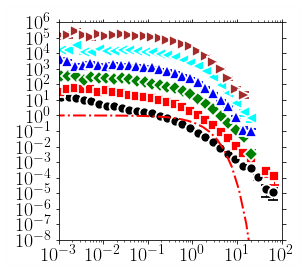

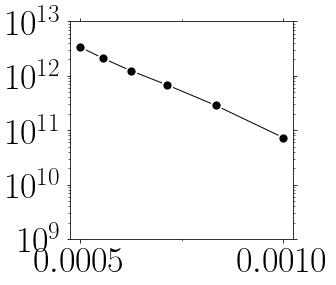

In [356]:
class Stats(Temperature):
    def __init__(self,temp_range,nrun,verbose=False):
        Temperature.__init__(self,temp_range,nrun)
        self.verbose = verbose
    #
    def PlotWaitTimes(self,scale=False,
                      scalePowerLaw=False,
                      shift=False,
                      n_per_decade=6,
                      **kwargs):
        #
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))
        #
        self.mean_rate = {}
        kount = 0
        #
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            data = self.data[kount:kount+self.nrun]
            data = list(map(lambda x:self.GetWaitTimes(x),data))
            if self.verbose:
                print('data.shape (per temperature):',np.array(data).shape)
            data = np.concatenate(data) #,axis=0)
            rate = 1.0 / data.mean()
            self.mean_rate[temp] = [ rate, rate*(1/len(data)**0.5)]
            if scale:
                data /= data.mean() 
            if self.verbose:
                print('data.shape (concatenated):',data.shape)
            #--- histogram
            hist, bin_edges, err = utl.GetPDF(data,n_per_decade=n_per_decade)
            if scalePowerLaw:
                alpha = 2 #1.5
                hist *= bin_edges ** alpha 
                err *= bin_edges ** alpha 
            #--- plot
            if shift:
                hist *= 10 ** indx 
                err *= 10 ** indx 
            utl.PltErr(bin_edges,hist,
                          yerr=err,
                   attrs=symbols.GetAttrs(count=indx%7,label=r'$%s$'%temp,fmt='.'),
                   ax = self.ax,
                   Plot=False,
                          )
            kount += self.nrun
        self.data_regr = np.c_[bin_edges,hist,err]
        #
        xhi=self.ax.axis()[1]
        xarr = np.logspace(np.log10(xhi)-5.0,np.log10(xhi),32)
        utl.PltErr( xarr if scale else None,
                   np.exp(-xarr) if scale else None,
                   attrs={'fmt':'-.r','lw':2},
                   ax=self.ax,
                   Plot=False,
                   
#                    legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
            
    def PlotAverageRate(self,**kwargs):
#        print(list(self.temps_runs))
#         self.ax = utl.PltErr(None,#ans[:,0],
#                         None,#1e8*ans[:,0],
#                         attrs={'fmt':'-.r'},Plot=False)

        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))
        data = list(map(lambda x:self.mean_rate[ x ][0], self.temps))
        err = list(map(lambda x:self.mean_rate[ x ][1], self.temps))
#             utl.PltErr(data[:,0],data[:,1],
#                    yerr=data[:,2],
#                    ax = self.ax,
#                    attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp),
#                    Plot=False,
#                   )

        utl.PltErr(1.0/np.array(self.temps),
                   data,
                   yerr=err,
                   attrs=symbols.GetAttrs(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
            
    
    def GetWaitTimes(self,times):
#         times = np.array(np.c_[self.lmpData.headers['Time'].iloc[0::2]].flatten())
        dtt = times[1:]-times[:-1]
        assert not np.any(dtt<0.0)
        filtr = dtt > 0.0
        return dtt[filtr]

    #
    def Barries(self):
        Barrier = self.lmpData.headers['Barrier'].iloc[1::2]        
        hist, bin_edges, err = utl.GetPDF(Barrier,linscale=True,n_per_decade=16)
        utl.PltErr(bin_edges,hist,
                  yerr=err,
                   attrs=symbols.GetAttrs(),
                   #yscale='log',
                   #xscale='log',
                   xstr=r'$\Delta E$',
                   ystr=r'$P(\Delta E)$'
                  )

    def func(self,x,k,alpha,beta,t0):
        return k*(x/t0)**(-alpha)/(1+(x/t0)**(beta-alpha))
    
    
    def fit(self,edge,hist,err):
        xdata=edge
        ydata=hist
        yerr=err
        popt, pcov = curve_fit(self.func,xdata,ydata,
                              p0=(1.0,0.4,2,1.0),
                               sigma=yerr,
                              )

        ax=utl.PltErr(edge,hist,yerr=err,
                   yscale='log',xscale='log',
                      Plot=False
                  )
        utl.PltErr(edge,self.func(edge,*popt),attrs={'fmt':'-.r'},
                   yscale='log',xscale='log',
                   ax=ax,
                   ylim=(1e-5,1000),
                  )
#        assert popt[-1]>0
        print('k,alpha,beta,t0',popt)
        return popt[0]

if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    
    stats = Stats(
         [1000,1200,1400,1600,1800,2000],8,
#        [1000,1200,1400,1600,1800,2000],1,
#        [2000],8,
#        np.arange(1000,1440,80),1,
#        verbose=True
                     )
#    stats.Parse(['msd/event_times.txt'])
#    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/event_times.txt'%(x[0],x[1]),
    stats.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/event_times.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiNatom1KTemp%sK/Run%s/msd/event_times.txt'%(x[0],x[1]),
                        stats.temps_runs ))
              )
    stats.PlotWaitTimes(scale=True,shift=True,scalePowerLaw=False,
                        n_per_decade=6,
                        **{'xscale':'log',
                  'yscale':'log',
                    'xlim':(1e-3,100),
                    'ylim':(1e-8,1e6), #(1e-5,1e2),
#                    'ndecade_y':2,
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
                   'title':'png/waitTimes_unscaled_ni.png'},

                       )
#     stats.PlotWaitTimes(scale=True,scalePowerLaw=True,
#                         **{'xscale':'log',
#                   'yscale':'log',
# #                   'xlim':(1e-9,1e-3),
#                    'ylim':(1e-5,1e0), #(1e-5,1e2),
# #                           'xstr':r'$\Delta t$',
# #                           'ystr':r'$P(\Delta t)$',
#                    'title':'png/waitTimes_rescaled_ni.png'},
#                       )
    stats.PlotAverageRate(
                **{
                    'fontsize':36,
#                  'xscale':'log',
                  'yscale':'log',
#                   'xlim':(1e-9,1e-3),
                   'ylim':(1e9,1e13), #(1e-5,1e2),
#                           'xstr':r'$1/T$',
#                           'ystr':r'$\lambda$',
                   'title':'png/eventRate_nicocr.png'},
    
    )
    #
#    stats.fit(stats.data_regr[:,0],stats.data_regr[:,1],stats.data_regr[:,2])
    #stats.Barries()

### effective E

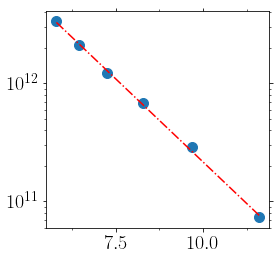

energy= 0.6495992792586722


In [357]:
def func(x,a,b):
    return a*np.exp(-b*x)

kb=8.61732814974056e-05
xdata = 1/(kb*np.array(stats.temps))
ydata = list(map(lambda x:stats.mean_rate[x][0],stats.temps))
yerr = list(map(lambda x:stats.mean_rate[x][1],stats.temps))
popt,pcov=curve_fit(func,xdata,ydata,
         p0=[1e12,1],
         sigma=yerr
         )
#
ax=utl.PltErr(xdata,ydata,yerr=yerr,
           fmt='.',
           Plot=False
          
          )
utl.PltErr(xdata,func(xdata,*popt),
           yscale='log',
           attrs={'fmt':'-.r'},
           ax=ax
          
          )
print('energy=',popt[1])

## jumps

mkdir: png: File exists


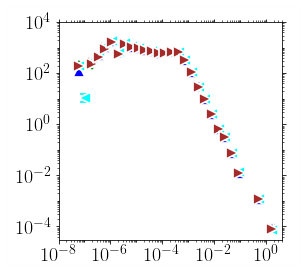

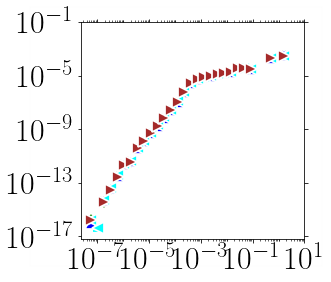

In [363]:
class JumpStats(Temperature):
    def __init__(self,temp_range,nrun,verbose=False):
        Temperature.__init__(self,temp_range,nrun)
        self.verbose = verbose
    #
    def PlotPdf(self,scale=False,**kwargs):
        #
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5))
        #
        self.mean_rate = {}
        kount = 0
        #
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            data = self.data[kount:kount+self.nrun][0]
            if self.verbose:
                print('data.shape (per temperature):',np.array(data).shape)
            if self.verbose:
                print('data.shape (concatenated):',data.shape)
            #--- histogram
#            data = np.array(data).flatten()
            hist = data[:,1]
            bin_edges = data[:,0]
            err = data[:,2]
            
            #--- remove count == 1
            filtr = err == hist
            hist = hist[~filtr]
            bin_edges = bin_edges[~filtr]
            err = err[~filtr]
            
            self.data_regr = np.c_[bin_edges,hist,err]
            if scale:
                hist *= bin_edges ** self.alpha
                err  *= bin_edges ** self.alpha
        #--- plot
#            temp= [1000,1200,1400,1600,1800,2000][indx]
            utl.PltErr(bin_edges,hist,
                          yerr=err,
                   attrs=symbols.GetAttrs(count=indx%7,label=r'$%s$'%temp,fmt='.'),
                   ax = self.ax,
                   Plot=False,
                          )
            kount+=self.nrun
        #
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
#                      legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
            
    def func(self,x,k,alpha):
        return k*x**alpha
    
    
    def fit(self,edge,hist,err):
        xdata=edge
        ydata=hist
        yerr=err
        popt, pcov = curve_fit(self.func,xdata,ydata,
                               p0=(1.0e-4,-2.0),
                               sigma=2*yerr,
                              )

        ax=utl.PltErr(edge,hist,yerr=2*err,fmt='.',
                   yscale='log',xscale='log',
                      Plot=False
                  )
        utl.PltErr(edge,self.func(edge,*popt),attrs={'fmt':'-.r'},
                   yscale='log',xscale='log',
                   ax=ax,
#                   ylim=(1e-5,1000),
                  )
#        assert popt[-1]>0
        print('k,alpha',popt)
        return popt[0]
    
if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    
    stats = JumpStats(
        [1000,1200,1400,1600,1800,2000],
#        [1000,1200,1400,1600,1800,2000],
#        np.arange(1000,1440,80),
        1,
#        verbose=True
                     )
#    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/event_jumps.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/event_jumps.txt'%(x[0],x[1]),
    stats.Parse( list(map(lambda x:'NiNatom1KTemp%sK/Run%s/msd/event_jumps.txt'%(x[0],x[1]),
                         stats.temps_runs ))
               )
    stats.PlotPdf(scale=False,
                        **{'xscale':'log',
                  'yscale':'log',
                   'xlim':(1e-8,4e0),
#                   'ylim':(1e-3,1e1), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
                        'ndecade_x':2,'ndecade_y':2,
                    'bbox_to_anchor':(0.56,0.27,0.5,0.5),
                   'title':'png/jumpsPdf_nicocr.png'},

                       )
    
    #--- rescale
    stats.alpha = 2.5 #2.8 #3.0#2.5
    stats.PlotPdf(scale=True,
                **{'xscale':'log',
                  'yscale':'log',
                   'fontsize':32,
#                   'xlim':(1e-8,2e0),
#                   'ylim':(1e-3,1e1), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
                        'ndecade_x':2,'ndecade_y':4,
                   'title':'png/jumpsPdf_rescaled_ni.png'},

                       )

### fit

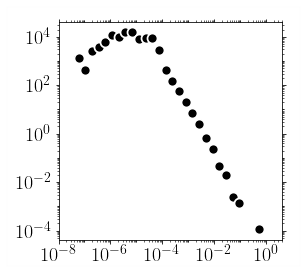

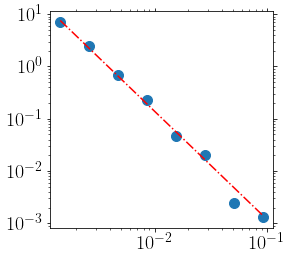

k,alpha [ 1.02005346e-05 -2.06802762e+00]


1.020053458672418e-05

In [317]:

    stats = JumpStats(
        [2000],1,
#        verbose=True
                     )
#    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/event_jumps.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/event_jumps.txt'%(x[0],x[1]),
    stats.Parse( list(map(lambda x:'NiNatom16KTemp%sK/Run%s/msd/event_jumps.txt'%(x[0],x[1]),
                         stats.temps_runs ))
               )
    stats.PlotPdf(scale=False,
                        **{'xscale':'log',
                  'yscale':'log',
                   'xlim':(1e-8,4e0),
#                   'ylim':(1e-3,1e1), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
                        'ndecade_x':2,'ndecade_y':2,
                    'bbox_to_anchor':(0.56,0.27,0.5,0.5),
#                    'title':'png/jumpsPdf_nicocr.png'
                          },

                       )
    filtr = np.all([stats.data_regr[:,0]>1e-3,stats.data_regr[:,0]<1e-1],axis=0)
    stats.fit(stats.data_regr[:,0][filtr],stats.data_regr[:,1][filtr],stats.data_regr[:,2][filtr])
    

In [ ]:
Energy = lmpData.headers['Energy']

In [ ]:
            data = self.data[kount:kount+self.nrun]
            if self.verbose:
                print('data.shape:',np.array(data).shape)
#             print('np.array(data):',np.array(data))
#             pdb.set_trace()
    
            filtr = list(map(lambda x:x.shape[0] > 0,data)) #--- filter empty arrays
    
            data = np.concatenate(np.array(data)[filtr]) #,axis=0)
            self.data_averaged[ temp ] = self.hist(data,log_scale)
            kount += self.nrun

## energy

### sampled energies

mkdir: png: File exists


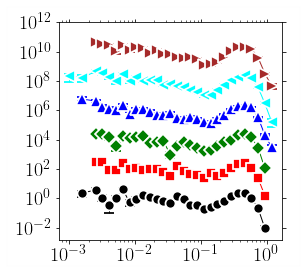

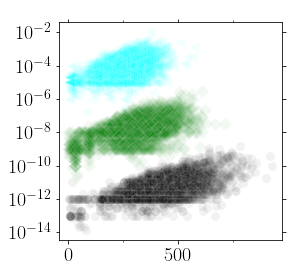

In [368]:
class EnergyStats(Temperature):
    def __init__(self,temp_range,nrun,verbose=False):
        Temperature.__init__(self,temp_range,nrun)
        self.verbose = verbose
    #
    def GetWaitTimes(self,times):
        times = times[0::2]
        dtt = times[1:]-times[:-1]
        assert not np.any(dtt<0.0)
#        filtr = dtt > 0.0
        return dtt#[filtr]
    #
    def PlotPdf(self,shift=False,column_energy = 0,n_per_decade=8,
                **kwargs):
        #
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs #plotAttrs
                    else (1.0,0.5,0.5,0.5))
        #
        self.mean_rate = {}
        #
        kount = 0
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp            
            data = np.concatenate(list(map(lambda x: self.data[x][:,column_energy],range(kount,kount+self.nrun))))
            #--- remove zeros
            data = data[data > 0.0]
            if self.verbose:
                print('data.shape (per temperature):',np.array(data).shape)
            if self.verbose:
                print('data.shape (concatenated):',data.shape)
            #--- histogram
#            data = np.array(data).flatten()
            #--- histogram
            hist, bin_edges, err = utl.GetPDF(data,n_per_decade=n_per_decade)
        
            #--- filtr
            filtr = hist == err
            hist = hist[~filtr]
            bin_edges = bin_edges[~filtr]
            err = err[~filtr]
        #--- plot
            if shift:
                hist *= 100**indx if shift else 1
                err *= 100**indx if shift else 1

            utl.PltErr(bin_edges,hist,
                          yerr=err,
                   attrs=symbols.GetAttrs(count=indx%7,label=r'$%s$'%temp), #,fmt='.'),
                   ax = self.ax,
                   Plot=False,
                          )
            kount += self.nrun
        #
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
                   
#                    legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
        
    def PlotPdfConcat(self,scale=False,
                      column_energy = 0,
                      type_column=0,
                      splitByType=True,
                      n_per_decade = 8,
                      **kwargs):
        #
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs #plotAttrs
                    else (1.0,0.5,0.5,0.5))
        #
        self.mean_rate = {}
        kount = 0
        #
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp            
#            data = np.concatenate(list(map(lambda x: self.data[x][:,column_energy],range(indx,indx+self.nrun))))
            data = np.concatenate(list(map(lambda x: self.data[x],range(kount,kount+self.nrun))))
#             types = np.concatenate(list(map(lambda x: self.data[x][:,type_column],range(indx,indx+self.nrun))))
            #--- remove zeros
#            data = data[data > 0.0]
            if self.verbose:
                print('data.shape (per temperature):',np.array(data).shape)
            if self.verbose:
                print('data.shape (concatenated):',data.shape)
            #--- histogram
#            data = np.array(data).flatten()
            #--- histogram
            data_concat = data.copy() if indx ==0 else np.concatenate([data_concat,data]) #np.c_[types,data] if indx ==0 else\
                        #np.concatenate([data_concat,np.c_[types,data]])
            kount += self.nrun
        if self.verbose:
            print('type.shape (concatenated):',data_concat.shape)
        
        #--- split by type
        if splitByType:
            df=pd.DataFrame(np.c_[data_concat[:,type_column],data_concat[:,column_energy]],
                            columns=['type','dE'])
            types=df.groupby(by='type').groups
            for itype in types:
                indices = types[itype]
                elist = np.array(df['dE'].iloc[indices])
                if self.verbose:
                    print('elist.shape:',elist.shape)

                #--- histogram
                hist, bin_edges, err = utl.GetPDF(elist,n_per_decade=n_per_decade)

                #--- filtr
                filtr = hist == err
                hist = hist[~filtr]
                bin_edges = bin_edges[~filtr]
                err = err[~filtr]
                #--- plot
                if scale:
                    hist *= 1000**int(itype)
                    err *= 1000**int(itype)
                utl.PltErr(bin_edges,hist,
                              yerr=err,
                       attrs=symbols.GetAttrs(count=int(itype-1)%7,label=r'$%s$'%itype), #,fmt='.'),
                       ax = self.ax,
                       Plot=False,
                              )
        else:
                data = data_concat[:,column_energy]
                data = data[data > 0.0]

                #--- histogram
                hist, bin_edges, err = utl.GetPDF(data,n_per_decade=n_per_decade)

                #--- filtr
                filtr = hist == err
                hist = hist[~filtr]
                bin_edges = bin_edges[~filtr]
                err = err[~filtr]
                #--- plot
#                 if scale:
#                     hist *= 100**int(itype)
#                     err *= 100**int(itype)
                utl.PltErr(bin_edges,hist,
                              yerr=err,
                       attrs=symbols.GetAttrs(count=0), #,label=r'$%s$'%itype),#,fmt='.'),
                       ax = self.ax,
                       Plot=False,
                              )
        #
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,

#                        legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )

    def Scatter(self,shift=False,nevery=1,**kwargs):
        kb_inv=8.61732814974056e05
        
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=Symbols(markersizes=np.array([10,10,10,12,12,12,10])*8)
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs #plotAttrs
                    else (1.0,0.5,0.5,0.5))

        #
        column_energy = 0
        column_time = 3
        kount = 0
        for indx in range(0,len(self.temps),nevery):
            temp = self.temps[indx]
            #--- concat. data for each temp            
            data_energy = np.concatenate(list(map(lambda x: self.GetEnergy(self.data[x][:,column_energy]),
                                                  range(kount,kount+self.nrun))))
            #--- wait_times
            data = self.data[indx:indx+self.nrun]
            data_waitTimes = np.concatenate(list(map(lambda x: self.GetWaitTimes(self.data[x][:,column_time]),
                                                     range(kount,kount+self.nrun))))

            if self.verbose:
                print('data_energy.shape (per temperature):',np.array(data_energy).shape)
                print('data_waitTimes.shape (per temperature):',np.array(data_waitTimes).shape)
            #--- plot scatter
            scale = 1e2 ** indx if shift else 1
            filtr = data_waitTimes > 0
#             utl.PltErr(data_energy[filtr]*kb_inv/temp,scale*data_waitTimes[filtr],
#                         attrs=symbols.GetAttrs(count=indx%7,label=r'$%s$'%temp,fmt='.',alpha=1.0),
#                         ax = self.ax,
#                         Plot=False,
#                         )
            self.ax.scatter(data_energy[filtr]*kb_inv/temp,scale*data_waitTimes[filtr],
                        **symbols.GetAttrsScatter(count=indx%7,label=r'$%s$'%temp,fmt='.',alpha=0.1/2),
                       )
            kount += self.nrun
            #--- plot average
#             nbins = 8
#             count, _=np.histogram(data_energy[filtr],bins=nbins)
#             xsum, _=np.histogram(data_energy[filtr],weights=data_energy[filtr],bins=nbins)
#             ysum, _=np.histogram(data_energy[filtr],weights=data_waitTimes[filtr],bins=nbins)
#             ysum /= count
# #            ysum =10 ** ysum 
#             xsum /= count
#             #---
#             utl.PltErr(xsum,ysum,
#                         attrs=symbols.GetAttrs(count=(indx)%7,label=r'$%s$'%temp,fmt='.'),
#                         ax = self.ax,
#                         Plot=False,
#                         )
        
        
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
#                     legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )

    def GetEnergy(self,slist):
        n=len(slist)
        return slist[1:n:2]
            
if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    
    stats = EnergyStats(
        [1000,1200,1400,1600,1800,2000],8,
#        [1000,1400,1800,2000],8,
#        [1000, 1400,1800],8,
        #        np.arange(1000,1440,40),1,
#        verbose=True
                     )
#    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/timeseries.txt'%(x[0],x[1]),
    stats.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/timeseries.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiNatom1KTemp%sK/Run%s/msd/timeseries.txt'%(x[0],x[1]),
                         stats.temps_runs ))
               )
    stats.PlotPdf(shift=True,n_per_decade=10,
                        **{'xscale':'log',
                  'yscale':'log',
#                   'xlim':(1e-3,1e0),
#                   'ylim':(1e-2,1e2), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
                        'ndecade_y':2,
                   'title':'png/BarrierPdf_cantor.png'},

                       )
    
#     stats.PlotPdfConcat(scale=False,
#                         splitByType = False,
#                         **{'xscale':'log',
#                       'yscale':'log',
#     #                   'xlim':(1e-3,1e0),
# #                        'ylim':(1e-2,1e2), #(1e-5,1e2),
#     #                           'xstr':r'$\Delta t$',
#     #                           'ystr':r'$P(\Delta t)$',
#     #                        'ndecade_x':2,'ndecade_y':2,
#     #                   'title':'png/BarrierPdf_cantor.png'
#                           },
#                        )

    stats.Scatter(nevery=2, shift = True,                        
                **{'xscale':'linear',
                  'yscale':'log',
#                   'xlim':(1e-3,1),
#                   'ylim':(1e-3,1e1), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
#                     'bbox_to_anchor':(0.56,0.27,0.5,0.5),
                        'ndecade_y':2,
                   'title':'png/twVsEnergy_nicocr.png',
                  }
)

### Events dir

mkdir: png: File exists


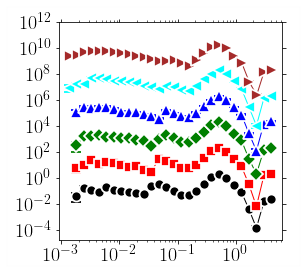

In [365]:
if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    
    stats = EnergyStats(
        [1000,1200,1400,1600,1800,2000],8,
#        [2000],8,
#        verbose=True
                     )
#    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/eventID_barrier.txt'%(x[0],x[1]),
    stats.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/eventID_barrier.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiNatom1KTemp%sK/Run%s/msd/eventID_barrier.txt'%(x[0],x[1]),
                         stats.temps_runs ))
               )
    stats.PlotPdf(shift=True,column_energy=3,
                        **{'xscale':'log',
                  'yscale':'log',
#                   'xlim':(1e-3,1e-1),
#                    'ylim':(1e-2,1e0), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
                        'ndecade_x':1,'ndecade_y':2,
                    'bbox_to_anchor':(0.4,0.13,0.5,0.5),
                   'title':'png/BarrierPdf_nicocr.png'},

                       )

#     stats.PlotPdfConcat(scale=True, 
#                         column_energy=3,
#                         splitByType = False,
#                         n_per_decade=10,
#                         **{'xscale':'log',
#                   'yscale':'log',
# #                   'xlim':(1e-3,1e-1),
# #                   'ylim':(1e-2,1e0), #(1e-5,1e2),
# #                           'xstr':r'$\Delta t$',
# #                           'ystr':r'$P(\Delta t)$',
# #                        'ndecade_x':2,'ndecade_y':2,
# #                   'title':'png/BarrierPdf_cantor.png'
#                           },

#                        )



In [ ]:
#alpha=-0.4

Emin=1e-2
Emax=1e1
n=100000
for alpha in [-1]:
    xmax=1/Emin**alpha
    xmin=1/Emax**alpha
    x=np.random.uniform(low=xmin,high=xmax,size=n)
    #E=np.exp(-E)
    E=x**-(1/alpha)
    hist, edge,err = utl.GetPDF(E,n_per_decade=4)
    ax=utl.PltErr(edge,hist,yerr=err,
               yscale='log',xscale='log',Plot=False,
              )

    utl.PltErr(edge,1/edge**(1+alpha),yerr=err,attrs={'fmt':'-.r'},
               yscale='log',xscale='log',
               ax=ax
              )

    #
    lambdaa=np.exp(-E)
    lambdaa = lambdaa[lambdaa>0]
    hist, edge,err = utl.GetPDF(lambdaa,n_per_decade=32)
    utl.PltErr(edge,hist,yerr=err,
               yscale='log',xscale='log',
               xlim=(1e-10,1),
              )

    sarr = np.c_[list(map(lambda x:np.random.exponential(1/x,size=1),lambdaa))].flatten()
    hist, edge,err = utl.GetPDF(sarr,n_per_decade=4)
    ax=utl.PltErr(edge,hist*edge**0,yerr=err*edge**0,
               yscale='log',xscale='log',
                  Plot=False
              )
    utl.PltErr(edge,1/edge**(1.5+alpha),attrs={'fmt':'-.r'},
               yscale='log',xscale='log',
               ax=ax
              )
    beta=fit(edge,hist,err)
    print(beta)
    plt.scatter(alpha,beta)
plt.show()

In [ ]:
def func(x,beta,k,x0,x1):
#    return k/(1+(x/x0)**beta)
    return k*np.exp(-x/x1)/(1+(x/x0)**beta)
    
def fit(edge,hist,err):
    xdata=edge
    ydata=hist
    yerr=err
    popt, pcov = curve_fit(func,xdata,ydata,
                          p0=(2,1,10,1e3),
                           sigma=yerr,
                          )

    ax=utl.PltErr(edge,hist,yerr=err,
               yscale='log',xscale='log',
                  Plot=False
              )
    utl.PltErr(edge,func(edge,*popt),attrs={'fmt':'-.r'},
               yscale='log',xscale='log',
               ax=ax,
               ndecade_x=4,
              )
    assert popt[-1]>0
    return popt[0]

In [ ]:
kbt=1000*8.61732814974056e-05
E=5e-2
print('%e'%(1.0/(1e-13*np.exp(E/kbt))))

In [ ]:
help(utl.GetPDF)

In [ ]:
help(np.random.exponential)

### catalogs

In [ ]:
if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    
    stats = EnergyStats(
#        [1000,1200,1400,1600,1800,2000],8,
        [2000],8
#        verbose=True
                     )
#    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/eventID_barrier_catalog_type5.txt'%(x[0],x[1]),
    stats.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/eventID_barrier_catalog_type3.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiNatom16KTemp%sK/Run%s/msd/timeseries.txt'%(x[0],x[1]),
                         stats.temps_runs ))
               )

    stats.PlotPdf( 
                        column_energy=2,
                        splitByType = False,
                        n_per_decade = 8,
                        **{'xscale':'log',
                  'yscale':'log',
#                   'xlim':(1e-3,1e0),
#                   'ylim':(1e-3,1e2), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
#                        'ndecade_x':2,'ndecade_y':2,
#                   'title':'png/BarrierPdf_cantor.png'
                          },

                       )

    

#     stats.Scatter(nevery=2,                        
#                 **{'xscale':'linear',
#                   'yscale':'log',
#                    'xlim':(0,1),
# #                   'ylim':(1e-3,1e1), #(1e-5,1e2),
# #                           'xstr':r'$\Delta t$',
# #                           'ystr':r'$P(\Delta t)$',
#                         'ndecade_y':2,
#                    'title':'png/twVsEnergy_cantor.png',
#                   }
# )

In [ ]:
times=lmpData.headers['Time']
plt.plot(times,np.ones(len(times)),'x')

In [ ]:
tt=np.array(times.iloc[0:-1:2])
dt=tt[1:]-tt[:-1]

In [ ]:
Barrier=lmpData.headers['Barrier']

plt.plot(Barrier,'x')

In [ ]:
barrier.shape

In [ ]:
barrier = np.array(Barrier.iloc[1:-1:2])
plt.scatter(dt,barrier[:-1])
plt.yscale('log')

In [ ]:
dt

In [ ]:
barrier

In [ ]:
plt.plot(lmpData.headers['Time'],Energy,'-o')